<a href="https://colab.research.google.com/github/DrAlexSanz/NLP-SPEC-C4/blob/main/W2/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2: Transformer Summarizer¶
Welcome to the second assignment of course 4. In this assignment you will explore summarization using the transformer model. Yes, you will implement the transformer decoder from scratch, but we will slowly walk you through it. There are many hints in this notebook so feel free to use them as needed.

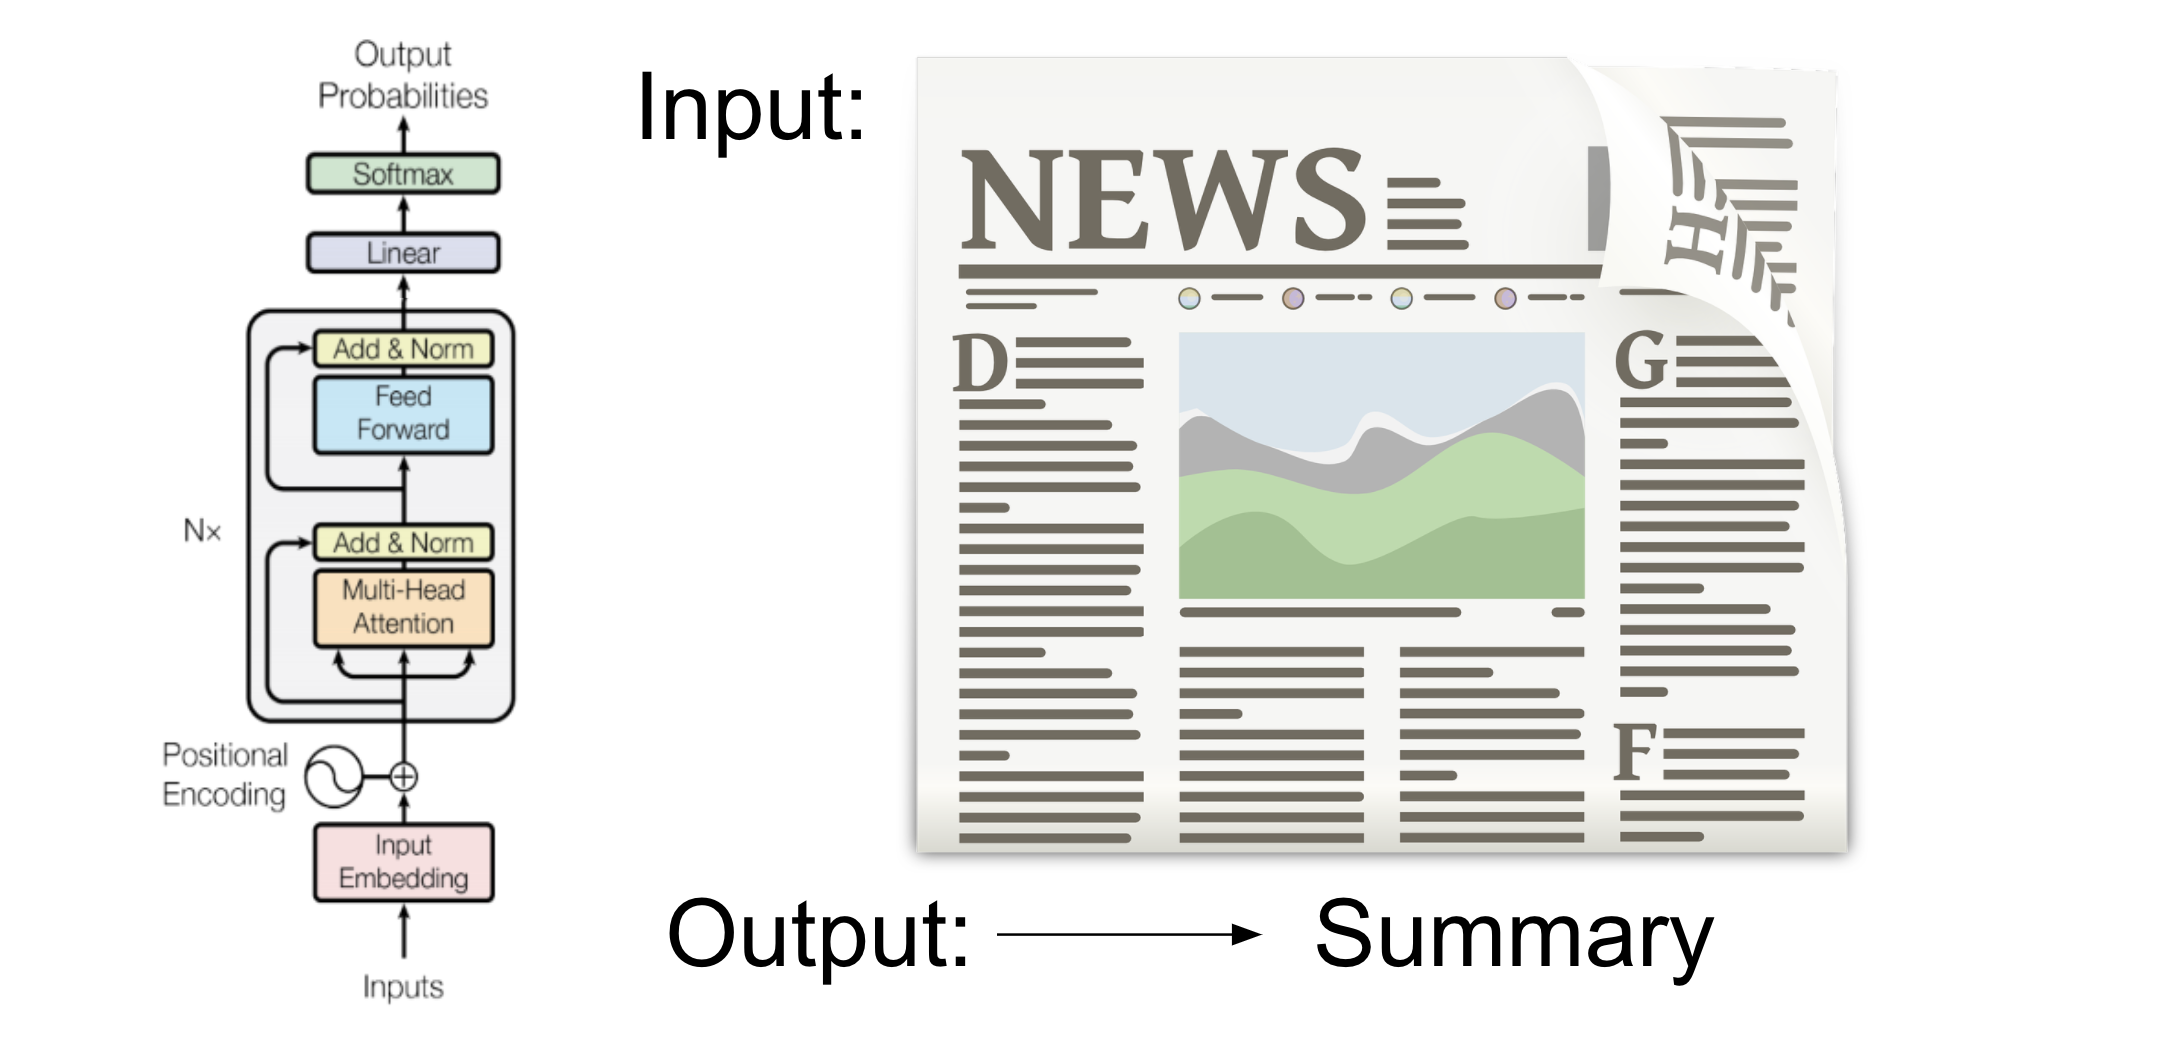

#Introduction
Summarization is an important task in natural language processing and could be useful for a consumer enterprise. For example, bots can be used to scrape articles, summarize them, and then you can use sentiment analysis to identify the sentiment about certain stocks. Anyways who wants to read an article or a long email today, when you can build a transformer to summarize text for you. Let's get started, by completing this assignment you will learn to:

* Use built-in functions to preprocess your data
* Implement DotProductAttention
* Implement Causal Attention
* Understand how attention works
* Build the transformer model
* Evaluate your model
* Summarize an article

As you can tell, this model is slightly different than the ones you have already implemented. This is heavily based on attention and does not rely on sequences, which allows for parallel computing.

In [2]:
!pip install trax

import sys
import os

import numpy as np

import textwrap
wrapper = textwrap.TextWrapper(width=70)

import trax
from trax import layers as tl
from trax.fastmath import numpy as jnp

# to print the entire np array
np.set_printoptions(threshold=sys.maxsize)

     |████████████████████████████████| 522kB 9.1MB/s 
     |████████████████████████████████| 215kB 18.8MB/s 
     |████████████████████████████████| 3.4MB 12.0MB/s 
     |████████████████████████████████| 3.8MB 59.8MB/s 
     |████████████████████████████████| 71kB 11.8MB/s 
     |████████████████████████████████| 1.8MB 57.5MB/s 
     |████████████████████████████████| 368kB 53.9MB/s 
     |████████████████████████████████| 1.2MB 57.3MB/s 
     |████████████████████████████████| 890kB 45.9MB/s 
     |████████████████████████████████| 2.9MB 45.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893261 sha256=92bc6f2004e30e4ee85a697f76e122a66a46c2978f400570e8a747ee6f9d5abe
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


#Part 1: Importing the dataset
Trax makes it easy to work with Tensorflow's datasets:

In [3]:
# This will download the dataset if no data_dir is specified.
# Downloading and processing can take bit of time,
# so we have the data already in 'data/' for you

# Importing CNN/DailyMail articles dataset
train_stream_fn = trax.data.TFDS('cnn_dailymail',
                                 data_dir='data/',
                                 keys=('article', 'highlights'),
                                 train=True)

# This should be much faster as the data is downloaded already.
eval_stream_fn = trax.data.TFDS('cnn_dailymail',
                                data_dir='data/',
                                keys=('article', 'highlights'),
                                train=False)

Dataset cnn_dailymail downloaded and prepared to data/cnn_dailymail/3.1.0. Subsequent calls will reuse this data.


## 1.1 Tokenize & Detokenize helper functions
Just like in the previous assignment, the cell above loads in the encoder for you. Given any data set, you have to be able to map words to their indices, and indices to their words. The inputs and outputs to your Trax models are usually tensors of numbers where each number corresponds to a word. If you were to process your data manually, you would have to make use of the following:

* word2Ind: a dictionary mapping the word to its index.
* ind2Word: a dictionary mapping the index to its word.
* word2Count: a dictionary mapping the word to the number of times it appears.
* num_words: total number of words that have appeared.

Since you have already implemented these in previous assignments of the specialization, we will provide you with helper functions that will do this for you. Run the cell below to get the following functions:

* tokenize: converts a text sentence to its corresponding token list (i.e. list of indices). Also converts words to subwords.
* detokenize: converts a token list to its corresponding sentence (i.e. string).